In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from datetime import timedelta
from datetime import datetime
import scipy.stats as stats

import requests as r
import pandas as pd
import seaborn as s
import numpy as np

import holidays
ie_holidays = holidays.Ireland()

import postgres
import gmaps
import googlemaps
import json
import math

import xgboost
from sklearn import metrics

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import pickle

In [2]:
import importlib
importlib.reload(postgres.config)

<module 'config' from '/media/storage/College/S3/Github/DublinBus/Analytics/config.py'>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# data = pd.read_csv("stored_queries/combined145.csv")
# data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']
# data.head(2)
# data.dtypes

In [5]:
# data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])
# data.lineid = data.lineid.astype('category')
# data.routeid= data.routeid.astype('category')
# data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'],inplace=True)

# Trips Data

In [6]:
tripsdata = pd.read_csv("stored_queries/trips_df.csv")
tripsdata.head()

,Unnamed: 0,dayofservice,tripid,lineid,routeid,direction,planned_arr,planned_dep,actual_arr,actual_dep
0,0,2018-06-17,7013606,7A,7A_85,1,66484,62400,67065.0,62901.0
1,1,2018-07-03,7137867,41C,41C_79,2,51620,47700,NaN,47293.0
2,2,2018-02-16,6258567,31,31_15,1,74041,71400,74297.0,71449.0
3,3,2018-08-27,7499178,67,67_6,2,59030,54720,NaN,54687.0
4,4,2018-08-27,7500294,44,44_36,2,85563,81000,85557.0,81004.0


In [7]:
tripsdata = tripsdata[['dayofservice', 'tripid', 'lineid', 'routeid', 'direction', 'actual_arr', 'actual_dep']]
tripsdata.dayofservice = pd.to_datetime(tripsdata.dayofservice)
tripsdata.dropna(inplace=True)

In [8]:
tripsdata['triplength'] = tripsdata.actual_arr - tripsdata.actual_dep
tripsdata.actual_arr = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_arr, unit='seconds')
tripsdata.actual_dep = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_dep, unit='seconds')
tripsdata['leavehour'] = tripsdata.actual_dep.dt.hour

In [9]:
tripsdata['weather_merge_time'] = tripsdata.actual_dep.dt.round('H') #  .dt is super useful. 

In [10]:
tripsdata.head()

,dayofservice,tripid,lineid,routeid,direction,actual_arr,actual_dep,triplength,leavehour,weather_merge_time
0,2018-06-17,7013606,7A,7A_85,1,2018-06-17 18:37:45,2018-06-17 17:28:21,4164.0,17,2018-06-17 17:00:00
2,2018-02-16,6258567,31,31_15,1,2018-02-16 20:38:17,2018-02-16 19:50:49,2848.0,19,2018-02-16 20:00:00
4,2018-08-27,7500294,44,44_36,2,2018-08-27 23:45:57,2018-08-27 22:30:04,4553.0,22,2018-08-27 23:00:00
5,2018-05-23,6782602,27,27_17,2,2018-05-23 19:37:32,2018-05-23 18:10:37,5215.0,18,2018-05-23 18:00:00
6,2018-02-16,6261199,53,53_20,1,2018-02-16 14:39:00,2018-02-16 14:01:04,2276.0,14,2018-02-16 14:00:00


# Weather Data

In [11]:
weather = pd.read_csv("stored_queries/weather.csv")

weather.icon = weather.icon.astype('category')
weather.dayofservice = pd.to_datetime(weather.dayofservice)

In [12]:
weather['rkey'] = weather.dayofservice + pd.to_timedelta(weather.hour, unit='hour')

# Combining Data

In [13]:
combinedtrip = tripsdata.merge(weather[['icon','temperature','humidity','windSpeed','rain','rkey','hour']], left_on='weather_merge_time', right_on='rkey', how='left')

## Adding features

Holidays

In [14]:
combinedtrip['holiday'] = combinedtrip.dayofservice.apply(lambda x: x in ie_holidays)

Weekday/Weekend

In [15]:
combinedtrip['weekend'] = combinedtrip.dayofservice.dt.weekday.isin([5,6])

# Outliers / Errors / Null Values

In [16]:
combinedtrip.drop(columns=['routeid','weather_merge_time','rkey','tripid','actual_arr','actual_dep','dayofservice'], inplace=True)

In [17]:
combinedtrip.dropna(inplace=True)

In [18]:
combinedtrip.head()

,lineid,direction,triplength,leavehour,icon,temperature,humidity,windSpeed,rain,hour,holiday,weekend
0,7A,1,4164.0,17,partly-cloudy-day,63.52,0.72,20.07,0.0,17.0,False,True
1,31,1,2848.0,19,partly-cloudy-night,42.09,0.89,8.29,0.0,20.0,False,False
2,44,2,4553.0,22,partly-cloudy-night,55.60,0.80,6.79,0.0,23.0,False,False
3,27,2,5215.0,18,partly-cloudy-day,58.99,0.65,10.25,0.0,18.0,False,False
4,53,1,2276.0,14,partly-cloudy-day,47.28,0.69,13.11,0.1,14.0,False,False


# Training Model

In [19]:
# need to put this in a loop over the pairs of stops. (unique)
target     = ['triplength']
predictors = ['hour','weekend','holiday','temperature','rain','humidity','windSpeed']#,'icon']

# plt.figure()
# for pr in predictors:
#     try:
        
#         combinedtrip[pr].hist(bins=100, normed=True)
#         print(pr)
#         plt.figure()
        
#     except Exception:
#         continue
        
# plt.show()

In [20]:
modeldata = combinedtrip[combinedtrip.lineid=='145']
modeldata = modeldata[modeldata.direction==1]
modeldata.head()
modeldata.dtypes

,lineid,direction,triplength,leavehour,icon,temperature,humidity,windSpeed,rain,hour,holiday,weekend
210,145,1,4814.0,20,partly-cloudy-day,69.74,0.65,8.71,0.0,20.0,False,True
268,145,1,4809.0,15,partly-cloudy-day,67.19,0.73,7.02,0.0,15.0,False,True
329,145,1,6441.0,16,partly-cloudy-day,63.90,0.77,13.85,0.0,17.0,False,False
406,145,1,3496.0,22,partly-cloudy-night,57.08,0.73,16.64,0.0,22.0,False,True
427,145,1,3222.0,17,partly-cloudy-night,58.96,0.80,16.90,0.5,18.0,False,False


lineid           object
direction         int64
triplength      float64
leavehour         int64
icon           category
temperature     float64
humidity        float64
windSpeed       float64
rain            float64
hour            float64
holiday            bool
weekend            bool
dtype: object

In [ ]:
train, test = train_test_split(modeldata, test_size = 0.3)
train.count()
test.count()

In [ ]:
RFM = RandomForestClassifier(n_estimators=200, max_features='auto', oob_score=True, random_state=1)
RFM.fit(train[predictors], train[target].values.ravel())

In [ ]:
feature_importance = pd.DataFrame({'feature':predictors, 'importance': RFM.feature_importances_})

feature_importance.set_index('feature', inplace=True)
feature_importance.plot.barh(title='Feature importance')

In [ ]:
RFM_predictions = RFM.predict(test[predictors])

(array([2.86847287e-07, 0.00000000e+00, 7.17118219e-07, 1.37686698e-05,
        2.15135466e-05, 3.04058125e-05, 2.29621254e-04, 5.66093122e-04,
        2.61461302e-04, 3.32742853e-05, 1.99358865e-05, 1.04699260e-05,
        1.00396551e-06, 2.86847287e-07, 1.43423644e-07, 0.00000000e+00,
        2.86847287e-07, 1.43423644e-07, 0.00000000e+00, 1.43423644e-07]),
 array([-6345.  , -5504.35, -4663.7 , -3823.05, -2982.4 , -2141.75,
        -1301.1 ,  -460.45,   380.2 ,  1220.85,  2061.5 ,  2902.15,
         3742.8 ,  4583.45,  5424.1 ,  6264.75,  7105.4 ,  7946.05,
         8786.7 ,  9627.35, 10468.  ]),
 <a list of 20 Patch objects>)

/home/ciaran/.conda/envs/BusEnv/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


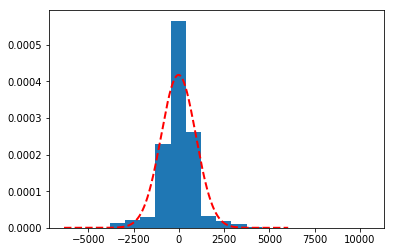

954.4836372409463 -22.221485411140584


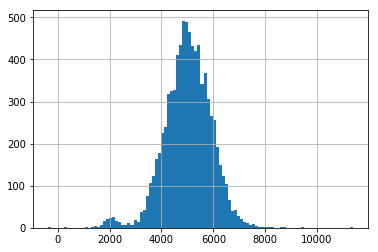

In [36]:
plt.hist(RFM_predictions - test.triplength, bins=20, density=True)


# # best fit of data
(mu, sigma) = stats.norm.fit(RFM_predictions - test.triplength)

# # the histogram of the data
# n, bins, patches = plt.hist(RFM_predictions - test.triplength, 2000, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.show()

print(sigma, mu)

test.triplength.hist(bins=100)

# Saving Model

In [ ]:
# save model
pickle.dump(model, open("ModelFiles/route145.sav", 'wb'))

# load model
loaded_model = pickle.load(open("ModelFiles/route145.sav", 'rb'))